In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [3]:
import time
from itertools import chain
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad, lax
from jax.tree_util import tree_map
import jax
import jaxlib
import pandas as pd
import optax
from itertools import chain

import jaxley as jx
from jaxley.channels import Leak
from jaxley_mech.channels.l5pc import *
from jaxley.optimize.utils import l2_norm

In [4]:
print(f"jax {jax.__version__}")
print(f"jaxlib {jaxlib.__version__}")
print(f"pandas {pd.__version__}")
print(f"optax {optax.__version__}")
print(f"numpy {np.__version__}")

jax 0.4.29
jaxlib 0.4.28
pandas 2.2.1
optax 0.2.2
numpy 1.26.4


In [5]:
def sample_within(n, bounds):
    return jnp.asarray(np.random.rand(n) * (bounds[1] - bounds[0]) + bounds[0])

In [6]:
bounds = {}
gt_apical = {}
gt_soma = {}
gt_axon = {}

bounds["apical_NaTs2T_gNaTs2T"] = [0, 0.04]
gt_apical["apical_NaTs2T_gNaTs2T"] = 0.026145

bounds["apical_SKv3_1_gSKv3_1"] = [0, 0.04]
gt_apical["apical_SKv3_1_gSKv3_1"] = 0.004226

bounds["apical_M_gM"] = [0, 0.001]
gt_apical["apical_M_gM"] = 0.000143

bounds["somatic_NaTs2T_gNaTs2T"] = [0.0, 1.0]
gt_soma["somatic_NaTs2T_gNaTs2T"] = 0.983955

bounds["somatic_SKv3_1_gSKv3_1"] = [0.25, 1]
gt_soma["somatic_SKv3_1_gSKv3_1"] = 0.303472

bounds["somatic_SKE2_gSKE2"] = [0, 0.1]
gt_soma["somatic_SKE2_gSKE2"] = 0.008407

bounds["somatic_CaPump_gamma"] = [0.0005,0.01]
gt_soma["somatic_CaPump_gamma"] = 0.000609

bounds["somatic_CaPump_decay"] = [20, 1_000]
gt_soma["somatic_CaPump_decay"] = 210.485291

bounds["somatic_CaHVA_gCaHVA"] = [0, 0.001]
gt_soma["somatic_CaHVA_gCaHVA"] = 0.000994

bounds["somatic_CaLVA_gCaLVA"] = [0, 0.01]
gt_soma["somatic_CaLVA_gCaLVA"] = 0.000333

bounds["axonal_NaTaT_gNaTaT"] = [0.0, 4.0]
gt_axon["axonal_NaTaT_gNaTaT"] = 3.137968

bounds["axonal_KPst_gKPst"] = [0.0, 1.0]
gt_axon["axonal_KPst_gKPst"] = 0.973538

bounds["axonal_KTst_gKTst"] = [0.0, 0.1]
gt_axon["axonal_KTst_gKTst"] = 0.089259

bounds["axonal_SKE2_gSKE2"] = [0.0, 0.1]
gt_axon["axonal_SKE2_gSKE2"] = 0.007104

bounds["axonal_SKv3_1_gSKv3_1"] = [0.0, 2.0]  # [0, 2.0]
gt_axon["axonal_SKv3_1_gSKv3_1"] = 1.021945

bounds["axonal_CaHVA_gCaHVA"] = [0, 0.001]  # 0.001
gt_axon["axonal_CaHVA_gCaHVA"] = 0.00099

bounds["axonal_CaLVA_gCaLVA"] = [0, 0.01]  # 0.01
gt_axon["axonal_CaLVA_gCaLVA"] = 0.008752

bounds["axonal_CaPump_gamma"] = [0.0005, 0.05]  # [0.0005,0.05]
gt_axon["axonal_CaPump_gamma"] = 0.00291

bounds["axonal_CaPump_decay"] = [20, 1_000]
gt_axon["axonal_CaPump_decay"] = 287.19873

In [7]:
nseg = 4
cell = jx.read_swc("../morphologies/bbp_with_axon.swc", nseg=nseg, max_branch_len=300.0, assign_groups=True)

soma_inds = np.unique(cell.group_nodes["soma"].branch_index).tolist()
apical_inds = np.unique(cell.group_nodes["apical"].branch_index).tolist()
basal_inds = np.unique(cell.group_nodes["basal"].branch_index).tolist()
axonal_inds = np.unique(cell.group_nodes["axon"].branch_index).tolist()

########## APICAL ##########
cell.apical.set("capacitance", 2.0)
cell.apical.insert(NaTs2T().change_name("apical_NaTs2T"))
cell.apical.insert(SKv3_1().change_name("apical_SKv3_1"))
cell.apical.insert(M().change_name("apical_M"))
cell.apical.insert(H().change_name("apical_H"))
for b in apical_inds:
    for c in [0.125, 0.375, 0.625, 0.875]:
        distance = cell.branch(b).loc(c).distance(cell.branch(0).loc(0.0))
        cond = (-0.8696 + 2.087* np.exp(distance*0.0031)) * 8e-5
        cell.branch(b).loc(c).set("apical_H_gH", cond)

########## SOMA ##########
cell.soma.insert(NaTs2T().change_name("somatic_NaTs2T"))
cell.soma.insert(SKv3_1().change_name("somatic_SKv3_1"))
cell.soma.insert(SKE2().change_name("somatic_SKE2"))
ca_dynamics = CaNernstReversal()
ca_dynamics.channel_constants["T"] = 307.15
cell.soma.insert(ca_dynamics)
cell.soma.insert(CaPump().change_name("somatic_CaPump"))
cell.soma.insert(CaHVA().change_name("somatic_CaHVA"))
cell.soma.insert(CaLVA().change_name("somatic_CaLVA"))
cell.soma.set("CaCon_i", 5e-05)
cell.soma.set("CaCon_e", 2.0)

########## BASAL ##########
cell.basal.insert(H().change_name("basal_H"))
cell.basal.set("basal_H_gH", 8e-5)

# ########## AXON ##########
cell.insert(CaNernstReversal())
cell.set("CaCon_i", 5e-05)
cell.set("CaCon_e", 2.0)

cell.axon.insert(NaTaT().change_name("axonal_NaTaT"))
cell.axon.set("axonal_NaTaT_gNaTaT", 3.137968)

cell.axon.insert(KTst().change_name("axonal_KTst"))
cell.axon.set("axonal_KTst_gKTst", 0.089259)

cell.axon.insert(CaPump().change_name("axonal_CaPump"))
cell.axon.set("axonal_CaPump_gamma", 0.00291)
cell.axon.set("axonal_CaPump_decay", 287.19873)

cell.axon.insert(SKE2().change_name("axonal_SKE2"))
cell.axon.set("axonal_SKE2_gSKE2", 0.007104)

cell.axon.insert(CaHVA().change_name("axonal_CaHVA"))
cell.axon.set("axonal_CaHVA_gCaHVA", 0.00099)

cell.axon.insert(KPst().change_name("axonal_KPst"))
cell.axon.set("axonal_KPst_gKPst", 0.973538)

cell.axon.insert(SKv3_1().change_name("axonal_SKv3_1"))
cell.axon.set("axonal_SKv3_1_gSKv3_1", 1.021945)

cell.axon.insert(CaLVA().change_name("axonal_CaLVA"))
cell.axon.set("axonal_CaLVA_gCaLVA", 0.008752)


########## WHOLE CELL  ##########
cell.insert(Leak())
cell.set("Leak_gLeak", 3e-05)
cell.set("Leak_eLeak", -75.0)

cell.set("axial_resistivity", 100.0)
cell.set("eNa", 50.0)
cell.set("eK", -85.0)
cell.set("v", -65.0)

In [8]:
res = 100
sigma = 400

evals = np.linspace(0, 1200, res)
kernel = np.zeros((res, res))
for ind_i, i in enumerate(evals):
    for ind_j, j in enumerate(evals):
        d = (i - j)**2
        kernel[ind_i, ind_j] = np.exp(-d / sigma**2)

def softplus(x):
    return np.log(1 + np.exp(x))

def inv_softplus(x: jnp.ndarray):
    """Inverse softplus."""
    return np.log(np.exp(x) - 1)

def sigmoid(x: jnp.ndarray) -> jnp.ndarray:
    """Sigmoid."""
    return 1 / (1 + jnp.exp(-1.5*x))

def expit(x: jnp.ndarray) -> jnp.ndarray:
    """Inverse sigmoid (expit)"""
    return -jnp.log(1 / x - 1)

def gaussian_cdf(x):
    return jax.scipy.stats.norm.cdf(x)

def sample_profile():
    profile = np.random.multivariate_normal(np.zeros((res)), kernel)
    return gaussian_cdf(profile) * 0.8 + 0.1

# For every parameter, sample the ground truth parameter function.
np.random.seed(2)
gt_profiles_apical = {}
gt_profiles_apical["apical_NaTs2T_gNaTs2T"] = sample_profile()
gt_profiles_apical["apical_SKv3_1_gSKv3_1"] = sample_profile()
gt_profiles_apical["apical_M_gM"] = sample_profile()

np.random.seed(22)
gt_profiles_axonal = {}
gt_profiles_axonal["axonal_NaTaT_gNaTaT"] = sample_profile()
gt_profiles_axonal["axonal_KPst_gKPst"] = sample_profile()
gt_profiles_axonal["axonal_KTst_gKTst"] = sample_profile()
gt_profiles_axonal["axonal_SKE2_gSKE2"] = sample_profile()
gt_profiles_axonal["axonal_SKv3_1_gSKv3_1"] = sample_profile()
gt_profiles_axonal["axonal_CaHVA_gCaHVA"] = sample_profile()
gt_profiles_axonal["axonal_CaLVA_gCaLVA"] = sample_profile()

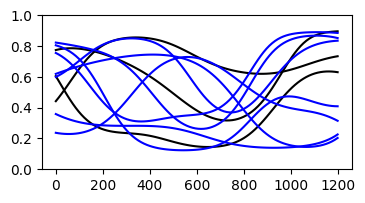

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
for item in gt_profiles_apical.values():
    _ = ax.plot(evals, item, c="k")
for item in gt_profiles_axonal.values():
    _ = ax.plot(evals, item, c="b")
_ = ax.set_ylim([0, 1])
plt.show()

In [10]:
# Apical.
for b in apical_inds:
    distance = cell.branch(b).loc(0.0).distance(cell.branch(0).loc(0.0))
    for key, item in gt_profiles_apical.items():
        cond = np.interp(distance, evals, item)
        cell.branch(b).set(key, cond * bounds[key][1])

for key in gt_soma.keys():
    cell.soma.set(key, gt_soma[key])

for b in axonal_inds:
    distance = cell.branch(b).loc(0.0).distance(cell.branch(0).loc(0.0))
    for key, item in gt_profiles_axonal.items():
        cond = np.interp(distance, evals, item)
        cell.branch(b).set(key, cond * bounds[key][1])

for key in gt_axon.keys():
    cell.axon.set(key, gt_axon[key])

In [11]:
def set_all_branches(params):
    """
    Args:
        params: Should have shape: (511,) (because 511 = 19x5 + 138x3 + 2)
    """
    counter = 0
    pstate = None

    # Apical.
    for key in gt_profiles_apical.keys():
        for b in apical_inds:
            pstate = cell.branch(b).data_set(key, params[counter], pstate)
            counter += 1
    
    # Soma.
    for key in gt_soma.keys():
        pstate = cell.soma.data_set(key, params[counter], pstate)
        counter += 1

    # Axon.
    for key in gt_profiles_axonal.keys():
        for b in axonal_inds:
            pstate = cell.branch(b).data_set(key, params[counter], pstate)
            counter += 1

    cell.axon.data_set("axonal_CaPump_gamma", params[counter], pstate)
    counter += 1
    cell.axon.data_set("axonal_CaPump_decay", params[counter], pstate)
    counter += 1

    assert counter == 1390  # last two don't increase counter
    return pstate

In [12]:
repeats = {
    "apical_NaTs2T_gNaTs2T": len(apical_inds),
    "apical_SKv3_1_gSKv3_1": len(apical_inds),
    "apical_M_gM": len(apical_inds), 
    "somatic_NaTs2T_gNaTs2T": 1,
    "somatic_SKv3_1_gSKv3_1": 1,
    "somatic_SKE2_gSKE2": 1,
    "somatic_CaHVA_gCaHVA": 1,
    "somatic_CaLVA_gCaLVA": 1,
    "somatic_CaPump_gamma": 1,
    "somatic_CaPump_decay": 1,
    "axonal_NaTaT_gNaTaT": len(axonal_inds),
    "axonal_KPst_gKPst": len(axonal_inds),
    "axonal_KTst_gKTst": len(axonal_inds),
    "axonal_SKE2_gSKE2": len(axonal_inds),
    "axonal_SKv3_1_gSKv3_1": len(axonal_inds),
    "axonal_CaHVA_gCaHVA": len(axonal_inds),
    "axonal_CaLVA_gCaLVA": len(axonal_inds),
    "axonal_CaPump_gamma": 1,
    "axonal_CaPump_decay": 1,
}
num_params = sum(list(repeats.values()))
print(f"Total number of parameters: {num_params}")

Total number of parameters: 1390


In [13]:
dt = 0.025
t_max = 5.0
time_vec = np.arange(0, t_max+2*dt, dt)

cell.delete_stimuli()
cell.delete_recordings()

i_delay = 0.0
i_dur = 3.0
i_amp = 3.0
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
cell.branch(soma_inds[0]).loc(0.0).stimulate(current)  # Stimulate soma
cell[range(0,339,1),0].record()

cell.set("v", -70.0)
cell.init_states()

Added 1 external_states. See `.externals` for details.
Added 339 recordings. See `.recordings` for details.


In [14]:
# fig, ax = plt.subplots(1, 1, figsize=(3, 5))
# _ = cell.vis(ax=ax, morph_plot_kwargs={"linewidth": 0.3})
# _ = cell[range(0,339,1)].vis(ax=ax, col="r")
# plt.show()

In [15]:
def simulate(params):
    parameters = set_all_branches(params)
    return jx.integrate(cell, param_state=parameters)

jitted_sim = jit(simulate)
vmapped_sim = jit(vmap(simulate, in_axes=(0,)))

def sim_gt():
    return jx.integrate(cell)

jitted_sim_gt = jit(sim_gt)

In [16]:
x_o = jitted_sim_gt()

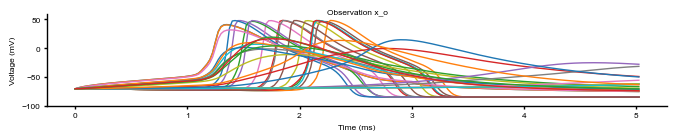

In [17]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 1.2))
    _ = ax.plot(time_vec, x_o[::10].T)
    _ = ax.set_ylim([-100, 60])
    _ = ax.set_title(f"Observation x_o", y=0.9)
    _ = ax.set_xlabel("Time (ms)")
    _ = ax.set_ylabel("Voltage (mV)")
    # plt.savefig("results/figs/observation.png", dpi=300, bbox_inches="tight")
    plt.show()

In [18]:
def loss_from_v(v):
    return jnp.mean(jnp.abs(v[:, 40:200:5] - x_o[:, 40:200:5]))

vmapped_loss_from_v = vmap(loss_from_v, in_axes=(0,))

In [19]:
def build_regularizer(inds):
    parents = cell.comb_parents
    apical_inds_from_zero = np.arange(len(inds))
    
    parents_of_apical = np.asarray(parents)[np.asarray(inds)]
    parent_is_also_apical = np.asarray([p in np.asarray(inds) for p in parents_of_apical])
    apical_inds_from_zero = apical_inds_from_zero[parent_is_also_apical]
    
    parents_of_apical = parents_of_apical[parent_is_also_apical]
    parents_from_zero = np.asarray([np.where(inds == p)[0][0] for p in parents_of_apical])
    
    return apical_inds_from_zero, parents_from_zero

In [20]:
param_child_apical, param_parent_apical = build_regularizer(apical_inds)
param_child_axonal, param_parent_axonal = build_regularizer(axonal_inds)

# Genetic algorithm

In [21]:
def loss_fn(opt_params):
    params = transform.forward(opt_params)
    vs = simulate(params)
    loss = loss_from_v(vs)
    return 1.0 * loss + 0.1 * regularizer(opt_params)

def regularizer(opt_params):
    reg_apical = 0.0
    reg_axonal = 0.0
    for key, i in zip(gt_profiles_apical, [0, 1, 2]):
        reg_apical += jnp.sum((opt_params[i][key][param_child_apical] - opt_params[i][key][param_parent_apical])**2)
    for key, i in zip(gt_profiles_axonal, np.arange(10, 20)):
        reg_axonal += jnp.sum((opt_params[i][key][param_child_axonal] - opt_params[i][key][param_parent_axonal])**2)
    return reg_apical + reg_axonal

jitted_loss_fn = jit(loss_fn)
grad_fn = jit(value_and_grad(loss_fn))

vmapped_regularizer = vmap(regularizer, in_axes=(0,))

In [22]:
def init():
    param_set = []
    for key in bounds:
        samples = sample_within(repeats[key], bounds[key]).tolist()
        param_set.append({key: jnp.asarray(samples)})
    return param_set

In [23]:
lowers = {}
uppers = {}
for key in bounds:
    lowers[key] = bounds[key][0]
    uppers[key] = bounds[key][1]

transform = jx.ParamTransform(
    lowers=lowers,
    uppers=uppers,
)

In [24]:
import bluepyopt as bpopt
from bluepyopt.parameters import Parameter


class HHEvaluator(bpopt.evaluators.Evaluator):
    def __init__(self, x_labels, params):
        super().__init__(objectives=x_labels, params=params)

    def init_simulator_and_evaluate_with_lists(self, param_list):
        global all_losses
        param_list = jnp.asarray(param_list)
        vs = vmapped_sim(param_list)

        opt_params = []
        counter = 0
        for key, num_repeats in repeats.items():
            opt_params.append({key: param_list[:, counter : counter + num_repeats]})
            counter += num_repeats
        opt_params = transform.inverse(opt_params)
        regularizers = vmapped_regularizer(opt_params)
        
        losses = vmapped_loss_from_v(vs)

        loss_plus_reg = losses + 0.001 * regularizers
        loss_for_ga = loss_plus_reg[:, None].tolist()
        print(f"{np.min(loss_for_ga)}")
        all_losses.append(np.min(loss_for_ga))
        return loss_for_ga


def map_fun(evaluate_with_lists, list_of_thetas):
    results = evaluate_with_lists(list_of_thetas)
    return results

In [25]:
x_labels = ["loss"]

params = []
for key in bounds:
    for r in range(repeats[key]):
        params.append(Parameter(f"{key}_{r}", bounds=bounds[key]))

all_losses = []
evaluator = HHEvaluator(x_labels, params)

opt = bpopt.deapext.optimisations.IBEADEAPOptimisation(
    evaluator,
    offspring_size=10,
    map_function=map_fun,
    seed=6,
    eta=10,
    mutpb=1.0,
    cxpb=1.0,
)

In [26]:
final_pop, halloffame, log, hist = opt.run(max_ngen=500)
print("Finished")

14.081221796860664
14.916954399808338
15.170069316300307
15.26053836705983
14.495630886679631
13.815195766171138
13.978516944666055
13.746028261238056
13.912811836012057
13.133368354772385
14.00879947303474
13.82293322547611
13.447674076352948
12.527372973403942
12.809068062225515
13.243706317900969
12.512216470411902
12.848900311867308
12.14391894445174
12.392909172737493
12.705038604636036
12.774868886820476
12.438085287128352
12.514855460749539
12.41956436452673
12.595351070682852
11.933832190987463
12.408166642941492
12.512549164407908
12.44387137496618
12.32079848272989
12.791781279823166
12.454663370089328
12.57779948354337
12.692547929849418
12.167553377516588
12.155373723575046
12.459111577682727
12.25286510109547
12.56691448257068
12.366291375696406
12.893368440033656
12.222626384357728
12.82652759041772
12.177831835518317
12.448772904879844
11.95535857673102
12.545064197418302
12.544153882640671
11.901157374626372
12.526575843437595
11.913211894611031
12.176207795859593
11.36

In [27]:
with open("../results/03_voltage_imaging/ga_losses.pkl", "wb") as handle:
    pickle.dump(all_losses, handle)